In [364]:
import pandas as pd
import catboost as cb
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

df = pd.read_csv("artDataset.csv")

df = df[df['yearCreation'].str.match(r'^\d{4}$')] 
df['yearCreation'] = pd.to_numeric(df['yearCreation'])
df_filtered = df[df['price'].str.contains(' USD', na=False)]
df_filtered['price'] = df_filtered['price'].str.replace(' USD', '').str.replace('.', '').astype(int)

In [365]:
# List of features to check within the 'signed' column
features = ['is_signed', 'dated', 'right', 'left']


# Iterate over the features list to create binary features based on the 'signed' column
for feature in features:
    keyword = feature  # Assuming the keyword matches the feature name directly
    if keyword == 'is_signed':  # Special case if you want to detect 'signed' specifically
        keyword = 'signed'
    df_filtered[feature] = df_filtered['signed'].str.contains(keyword, case=False, na=False).astype(int)


# Create binary features for 'condition'
# Assuming 'condition' is the correct column name for condition descriptions
conditions = ['excellent', 'direct from publisher', 'frame abrasion', 'original condition', 'very good', 'not examined', 'occasional marks', 'oxidation', 'scratches']
for condition in conditions:
    df_filtered[f'{condition.replace(" ", "_")}'] = df_filtered['condition'].str.contains(condition, case=False, na=False).astype(int)


In [366]:
#Hyperparameter Tuning

df_filtered.columns.tolist()

df_filtered.drop(columns=['artist', 'Unnamed: 0', 'title', 'signed', 'condition'], inplace=True)


# Manually specifying categorical features
categorical_features = ['period', 'movement']

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Define the ranges for hyperparameters
# param_dist = {
#     'depth': [4, 6, 8],
#     'learning_rate': [0.01, 0.1, 0.5],
#     'iterations': [500, 1000, 1500],
# }

# Initialize the CatBoostRegressor
cb_model = CatBoostRegressor(cat_features=categorical_features, eval_metric='RMSE', verbose=200)

# # Set up the random search with cross-validation
# random_search = RandomizedSearchCV(estimator=cb_model, param_distributions=param_dist, n_iter=10, cv=3, scoring='neg_mean_squared_error', verbose=2)

# # Fit the random search to the data
# random_search.fit(X_train, y_train)

# Print the best parameters
# print("Best parameters found: ", random_search.best_params_)

# Initialize CatBoostRegressor with best parameters
# best_params = random_search.best_params_
model = CatBoostRegressor(
    iterations=1500,
    learning_rate=0.1,
    depth=6,
    cat_features=categorical_features,
    eval_metric='RMSE',
    verbose=200
)

# Fit the model with the best parameters
model.fit(X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, verbose=True)

0:	learn: 12769.3679059	test: 10625.4163511	best: 10625.4163511 (0)	total: 8.36ms	remaining: 12.5s
1:	learn: 12570.3240927	test: 10517.7609075	best: 10517.7609075 (1)	total: 12.7ms	remaining: 9.48s
2:	learn: 12422.4367777	test: 10487.2133284	best: 10487.2133284 (2)	total: 15.4ms	remaining: 7.66s
3:	learn: 12282.8368644	test: 10446.1886618	best: 10446.1886618 (3)	total: 17.1ms	remaining: 6.39s
4:	learn: 12165.8112401	test: 10441.9970600	best: 10441.9970600 (4)	total: 21.6ms	remaining: 6.45s
5:	learn: 12067.3448913	test: 10452.1061036	best: 10441.9970600 (4)	total: 23.8ms	remaining: 5.93s
6:	learn: 11962.4504660	test: 10430.5831414	best: 10430.5831414 (6)	total: 25.4ms	remaining: 5.42s
7:	learn: 11882.7670971	test: 10386.5034989	best: 10386.5034989 (7)	total: 29.3ms	remaining: 5.46s
8:	learn: 11786.4577048	test: 10377.6735580	best: 10377.6735580 (8)	total: 30.5ms	remaining: 5.05s
9:	learn: 11721.2211877	test: 10347.1347670	best: 10347.1347670 (9)	total: 32.5ms	remaining: 4.85s
10:	learn:

In [367]:
print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'depth': 6, 'iterations': 1500, 'learning_rate': 0.01}


In [374]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

# Calculate R²
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2}")

# Calculate Adjusted R²
n = X_test.shape[0]  # Number of observations
p = X_test.shape[1]  # Number of independent variables
adjusted_r2 = 1 - (1-r2)*(n-1)/(n-p-1)
print(f"Adjusted R²: {adjusted_r2}")


import pandas as pd

# Get feature importances
feature_importances = model.get_feature_importance()
features = X_train.columns.tolist()

# Create a DataFrame to display feature importance
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print(feature_importance_df)



Root Mean Squared Error (RMSE): 10347.134766990788
R²: 0.06703782536700553
Adjusted R²: -0.0745725047112169
                  Feature  Importance
0               excellent   50.858972
1                  period   14.177459
2                movement   13.769233
3            not_examined    9.259292
4            yearCreation    9.119574
5               is_signed    1.843217
6                    left    0.581838
7               very_good    0.296340
8      original_condition    0.052118
9        occasional_marks    0.041958
10              oxidation    0.000000
11                  tears    0.000000
12  direct_from_publisher    0.000000
13         frame_abrasion    0.000000
14                  right    0.000000
15                  dated    0.000000
16              scratches    0.000000


In [369]:
synthetic_data = {
    'yearCreation': '2010',
    'period': 'Contemporary',  # Placeholder text; replace with an actual period if needed
    'movement': 'Abstract',  # Placeholder text; replace with an actual movement if needed
    'is_signed': 1,
    'dated': 0,
    'right': 1,
    'left': 0,
    'excellent': 0,
    'direct_from_publisher': 0,
    'frame_abrasion': 0,
    'original_condition': 1,
    'very_good': 0,
    'not_examined': 0,
    'tears': 0,
    'occasional_marks': 0,
    'oxidation': 0,
    'scratches': 0
}

df_synthetic = pd.DataFrame([synthetic_data])
predicted_price = model.predict(df_synthetic)
print("Predicted Price:", predicted_price)


Predicted Price: [5364.45295338]


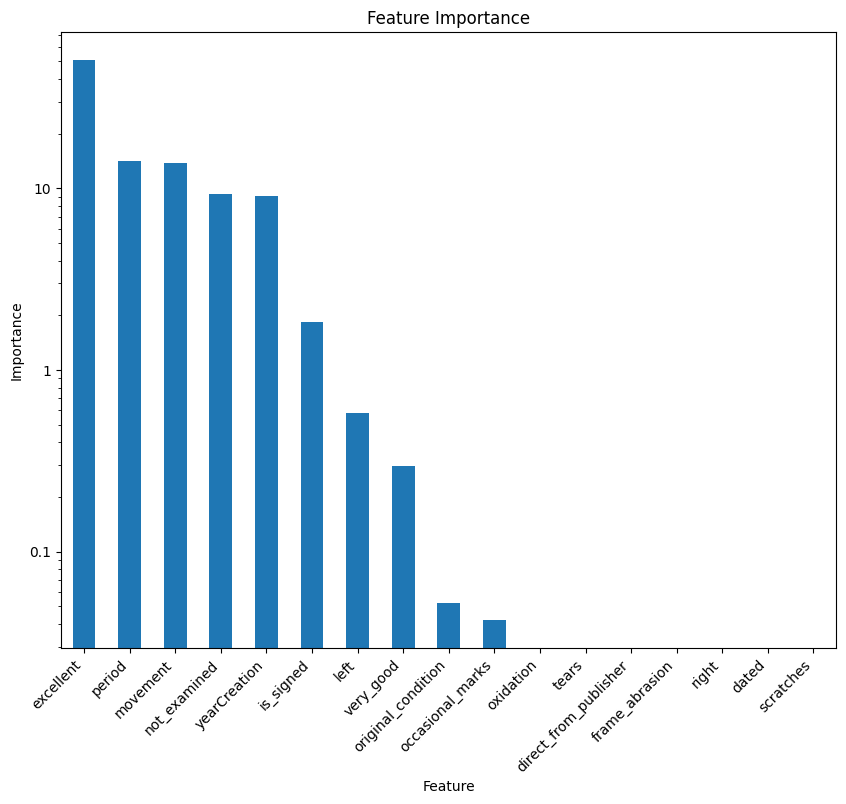

In [370]:
import matplotlib.pyplot as plt

# Get feature importance
feature_importances = model.get_feature_importance()
feature_names = X_train.columns

# Create a pandas series to make sorting easier
import pandas as pd
feature_importance_series = pd.Series(feature_importances, index=feature_names).sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 8))
feature_importance_series.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')

# Set y-axis to log scale
plt.yscale('log')

# Label y-axis with 0.1, 1, and 10
plt.yticks([0.1, 1, 10], ['0.1', '1', '10'])

plt.show()


In [371]:
# Group the data by 50-year intervals
df_grouped = df_plot.groupby(pd.cut(df_plot['yearCreation'], bins=range(1900, 2051, 50))).mean()

# Create the bar plot
plt.figure(figsize=(12, 8))
df_grouped[['Actual Price', 'Predicted Price']].plot(kind='bar', alpha=0.5)

# Customize plot aesthetics
plt.title('Average vs Actual Predicted Price by 50-Year Group', fontsize=16)
plt.xlabel('Year Group', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.legend(fontsize=12)
plt.grid(False)  # Remove gridlines

# Show the plot
plt.tight_layout()
plt.show()

TypeError: '<' not supported between instances of 'int' and 'str'

In [381]:
def predict_price(yearCreation, period, movement, is_signed, dated, right, left, excellent, direct_from_publisher, frame_abrasion, original_condition, very_good, not_examined, tears, occasional_marks, oxidation, scratches):
    # Create a dictionary with the input values
    synthetic_data = {
        'yearCreation': yearCreation,
        'period': period,
        'movement': movement,
        'is_signed': is_signed,
        'dated': dated,
        'right': right,
        'left': left,
        'excellent': excellent,
        'direct_from_publisher': direct_from_publisher,
        'frame_abrasion': frame_abrasion,
        'original_condition': original_condition,
        'very_good': very_good,
        'not_examined': not_examined,
        'tears': tears,
        'occasional_marks': occasional_marks,
        'oxidation': oxidation,
        'scratches': scratches
    }

    # Create a dataframe with the synthetic data
    df_synthetic = pd.DataFrame([synthetic_data])

    # Predict the price using the model
    predicted_price = model.predict(df_synthetic)

    # Return the predicted price
    return predicted_price


# Use the predict_price function on dataset 1
predicted_price_1 = predict_price(2009, 'Contemporary', 'Abstract', 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0)
print("Predicted Price for Dataset 1:", predicted_price_1)

# Use the predict_price function on dataset 2
predicted_price_2 = predict_price(2005, 'Modern', 'Impressionism', 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0)
print("Predicted Price for Dataset 2:", predicted_price_2)

Predicted Price for Dataset 1: [5415.1286145]
Predicted Price for Dataset 2: [7517.17014049]
